In [59]:
#Read the dataset
import tarfile
dataset = tarfile.open('flower_photos.tgz')

In [60]:
#Print all the directories
for name in dataset.getnames():
    tar_member = dataset.getmember(name)
    if(tar_member.isdir()):
         print(name)

flower_photos
flower_photos/roses
flower_photos/sunflowers
flower_photos/tulips
flower_photos/daisy
flower_photos/dandelion


## Building Info on the dataset

In [61]:
import pandas as pd
df = pd.DataFrame(columns=['class','dir','image_file'])

In [62]:
#Run through tarfile members 
for name in dataset.getnames():
    
    tar_mem = dataset.getmember(name)
    
    #Check if it is a file
    if(tar_mem.isfile() and name.endswith('.jpg')):
        #Build directory and class info
        im_dir = name[0:name.rfind('/')]
        im_class = im_dir[im_dir.rfind('/')+1:]
        #Add record to the dataframe
        df.loc[df.shape[0]] = [im_class, im_dir, name]
        

In [63]:
#Check contents of the dataframe
print('Total images: ', df.shape[0])
df.head()

Total images:  3670


,class,dir,image_file
0,roses,flower_photos/roses,flower_photos/roses/14810868100_87eb739f26_m.jpg
1,roses,flower_photos/roses,flower_photos/roses/1446090416_f0cad5fde4.jpg
2,roses,flower_photos/roses,flower_photos/roses/15319767030_e6c5602a77_m.jpg
3,roses,flower_photos/roses,flower_photos/roses/15032112248_30c5284e54_n.jpg
4,roses,flower_photos/roses,flower_photos/roses/7211616670_2d49ecb3a5_m.jpg


In [64]:
#images by class
print(df.groupby(['class']).size())

class
daisy         633
dandelion     898
roses         641
sunflowers    699
tulips        799
dtype: int64


In [65]:
df.shape

(3670, 3)

## Extract all images to disk

In [66]:
#extract data
dataset.extractall(path='data/')

## Create training and test dataset 

In [67]:
from sklearn.model_selection import train_test_split
train_df, test_df = train_test_split(df, test_size=0.2, random_state=42)

In [68]:
train_df.to_csv('data/flower_photos/train.csv',index=False)
test_df.to_csv('data/flower_photos/test.csv', index=False)

In [69]:
import tensorflow as tf

##  Load image from the disk 

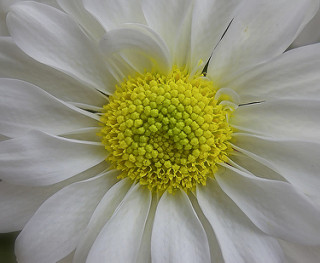

In [70]:
#Load an image using Keras image class
image_file = 'data/flower_photos/daisy/100080576_f52e8ee070_n.jpg'
flower_image = tf.keras.preprocessing.image.load_img(image_file)

#Inspect image
flower_image

In [71]:
type(flower_image)

PIL.JpegImagePlugin.JpegImageFile

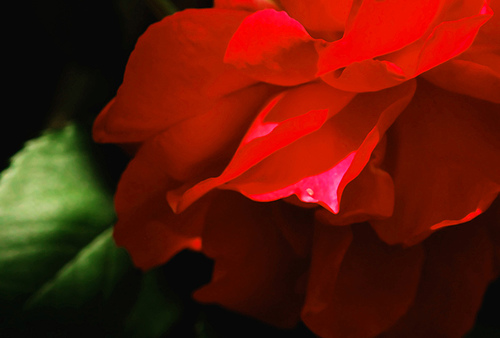

In [72]:
flower_image2=tf.keras.preprocessing.image.load_img('data/flower_photos/roses/512578026_f6e6f2ad26.jpg')
flower_image2

## Image Size 

In [73]:
print(flower_image.size)
print(flower_image2.size)

(320, 263)
(500, 338)


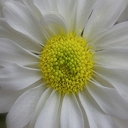

In [74]:
flower_image=flower_image.resize([128,128])
flower_image

## Converting image to numpy array for ML 

In [75]:
flower_array = tf.keras.preprocessing.image.img_to_array(flower_image)
print('Shape of numpy array', flower_array.shape)

Shape of numpy array (128, 128, 3)


In [76]:
flower_array

array([[[137., 137., 135.],
        [144., 145., 145.],
        [148., 149., 149.],
        ...,
        [153., 153., 151.],
        [154., 154., 153.],
        [152., 152., 153.]],

       [[136., 136., 134.],
        [144., 143., 143.],
        [148., 147., 148.],
        ...,
        [154., 154., 152.],
        [153., 153., 152.],
        [150., 150., 150.]],

       [[135., 134., 130.],
        [142., 141., 138.],
        [146., 144., 144.],
        ...,
        [156., 156., 154.],
        [152., 152., 151.],
        [147., 147., 147.]],

       ...,

       [[ 44.,  46.,  26.],
        [ 44.,  46.,  26.],
        [ 44.,  46.,  26.],
        ...,
        [129., 125., 124.],
        [128., 124., 123.],
        [130., 126., 125.]],

       [[ 44.,  47.,  26.],
        [ 44.,  47.,  26.],
        [ 45.,  48.,  27.],
        ...,
        [131., 127., 126.],
        [130., 126., 125.],
        [130., 126., 125.]],

       [[ 44.,  47.,  26.],
        [ 44.,  47.,  26.],
        [ 45.,  

## Converting numpy array to image

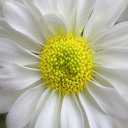

In [77]:
new_image = tf.keras.preprocessing.image.array_to_img(flower_array)

#Show image
new_image

## Read training and test data

In [88]:
train_df = pd.read_csv('data/flower_photos/train.csv')
test_df = pd.read_csv('data/flower_photos/test.csv')

In [89]:
#Get class names
class_names = train_df['class'].unique().tolist()
print('Flower classes: ', class_names)

Flower classes:  ['tulips', 'daisy', 'sunflowers', 'dandelion', 'roses']


In [90]:
#Define some parameters
img_size = 60
img_depth = 3  

## Build batch generator

In [93]:
import numpy as np

In [95]:
def batch_generator(df, batchsize=32):   
    
    while True:       
                
        #Generate random numbers to pick images from dataset
        batch_nums = np.random.randint(0,df.shape[0], batchsize)
        
        #Initialize batch images array
        batch_images = np.zeros((batchsize,img_size, img_size,img_depth))
        
        #Initiate batch label array
        batch_labels = np.zeros((batchsize, len(class_names)))
        
        for i in range(batchsize):
            
            #Load image
            flower_image =  tf.keras.preprocessing.image.load_img('data/' + 
                                                                  df.loc[batch_nums[i]]['image_file'],
                                                                  target_size=(img_size, img_size))
            #Convert to array
            flower_image = tf.keras.preprocessing.image.img_to_array(flower_image)
            
            #Get the class
            img_class = df.loc[batch_nums[i]]['class']
            #Convert class to number
            img_class = class_names.index(img_class)
            #Convert class to one hot encoding
            img_class = tf.keras.utils.to_categorical(img_class, num_classes=len(class_names))
            
            #Update batch images and class arrays
            batch_images[i] = flower_image
            batch_labels[i] = img_class        
        
        yield batch_images, batch_labels          

## Build CNN Model 

In [96]:
model = tf.keras.models.Sequential()

#Add Layers
model.add(tf.keras.layers.BatchNormalization(input_shape=(img_size,img_size,3,)))
model.add(tf.keras.layers.Conv2D(32, kernel_size=(3,3), activation='relu'))
model.add(tf.keras.layers.Conv2D(64, kernel_size=(3,3), activation='relu'))
model.add(tf.keras.layers.MaxPool2D(pool_size=(2,2)))
model.add(tf.keras.layers.Flatten())
model.add(tf.keras.layers.Dense(128, activation='relu'))
model.add(tf.keras.layers.Dropout(0.25))
model.add(tf.keras.layers.Dense(len(class_names), activation='softmax'))

In [97]:
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [98]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 batch_normalization (BatchN  (None, 60, 60, 3)        12        
 ormalization)                                                   
                                                                 
 conv2d (Conv2D)             (None, 58, 58, 32)        896       
                                                                 
 conv2d_1 (Conv2D)           (None, 56, 56, 64)        18496     
                                                                 
 max_pooling2d (MaxPooling2D  (None, 28, 28, 64)       0         
 )                                                               
                                                                 
 flatten (Flatten)           (None, 50176)             0         
                                                                 
 dense (Dense)               (None, 128)               6

## Train the model 

In [99]:
#Create train and test generator
batchsize = 64
train_generator = batch_generator(train_df, batchsize=batchsize) #batchsize can be changed
test_generator = batch_generator(test_df, batchsize=batchsize)

In [100]:
model.fit_generator(train_generator, 
                          epochs=10,
                          steps_per_epoch= train_df.shape[0]//batchsize,
                          validation_data=test_generator,
                          validation_steps = test_df.shape[0]//batchsize)

<ipython-input-100-8277d2b82f91>:1: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  model.fit_generator(train_generator,


Epoch 1/10
45/45 [==============================] - 37s 820ms/step - loss: 1.9634 - accuracy: 0.3233 - val_loss: 1.3068 - val_accuracy: 0.3565
Epoch 2/10
45/45 [==============================] - 28s 630ms/step - loss: 1.1283 - accuracy: 0.5372 - val_loss: 1.2731 - val_accuracy: 0.4659
Epoch 3/10
45/45 [==============================] - 26s 583ms/step - loss: 0.8619 - accuracy: 0.6823 - val_loss: 1.0251 - val_accuracy: 0.6108
Epoch 4/10
45/45 [==============================] - 23s 512ms/step - loss: 0.6301 - accuracy: 0.7733 - val_loss: 0.9398 - val_accuracy: 0.5895
Epoch 5/10
45/45 [==============================] - 23s 505ms/step - loss: 0.4325 - accuracy: 0.8587 - val_loss: 1.1247 - val_accuracy: 0.6023
Epoch 6/10
45/45 [==============================] - 23s 506ms/step - loss: 0.3153 - accuracy: 0.8990 - val_loss: 1.0601 - val_accuracy: 0.6264
Epoch 7/10
45/45 [==============================] - 22s 501ms/step - loss: 0.2005 - accuracy: 0.9392 - val_loss: 1.1029 - val_accuracy: 0.6222

In [101]:
## This is overfitting

## Image Augmentation

In [102]:
import tensorflow as tf
import matplotlib.pyplot as plt

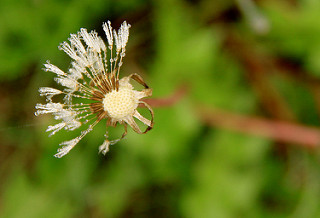

In [108]:
#Load image from disk

image_file='data/flower_photos/dandelion/10200780773_c6051a7d71_n.jpg'
flower_image=tf.keras.preprocessing.image.load_img(image_file)
flower_array=tf.keras.preprocessing.image.img_to_array(flower_image)

flower_image

### Build a function to display original and transformed image 

In [109]:
def plot_images(original_image, updated_image):
    
    plt.figure(figsize=(15,8))
    #Original image
    plt.subplot(1,2,1)
    plt.title('Original image')
    plt.imshow(original_image)

    #Transformed image
    plt.subplot(1,2,2)
    plt.title('Transformed image')
    plt.imshow(updated_image)

    plt.show()

### Flip an Image 

In [118]:
transform_fn=tf.keras.preprocessing.image.ImageDataGenerator(horizontal_flip=True)

transformed_array = transform_fn.random_transform(flower_array)
transformed_image = tf.keras.preprocessing.image.array_to_img(transformed_array)

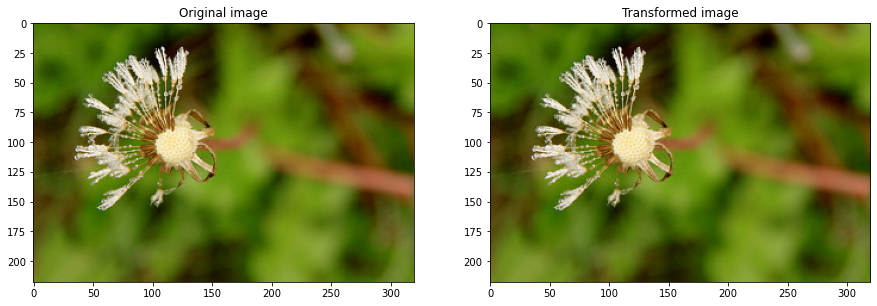

In [119]:
plot_images(flower_image, transformed_image)

### Shifting Image

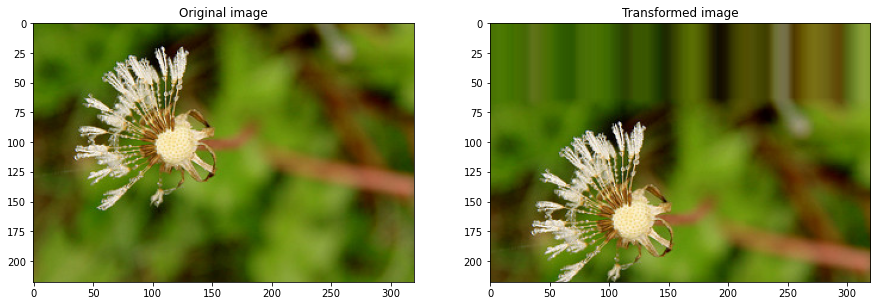

In [125]:
transform_fn=tf.keras.preprocessing.image.ImageDataGenerator(height_shift_range=70)
transformed_array=transform_fn.random_transform(flower_array)
transformed_image=tf.keras.preprocessing.image.array_to_img(transformed_array)

plot_images(flower_image,transformed_image)

### Rotating Image

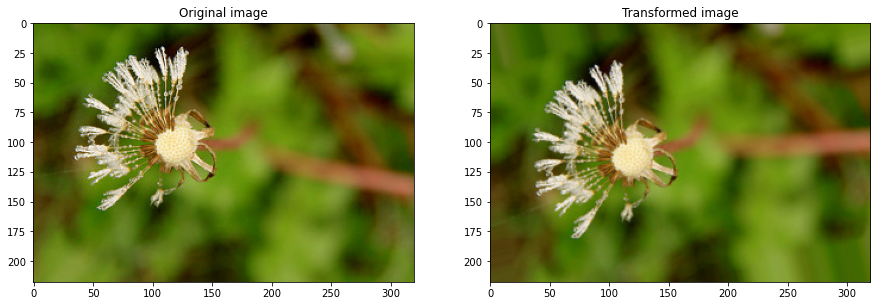

In [127]:
transform_fn = tf.keras.preprocessing.image.ImageDataGenerator(rotation_range=100)
transformed_array = transform_fn.random_transform(flower_array)
transformed_image = tf.keras.preprocessing.image.array_to_img(transformed_array)

plot_images(flower_image, transformed_image)

### Zooming Image 

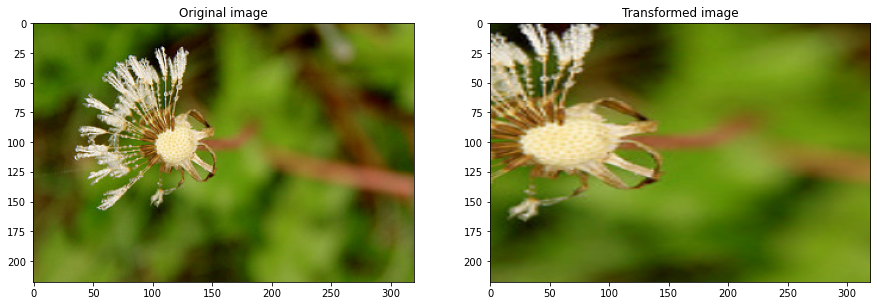

In [128]:
transform_fn = tf.keras.preprocessing.image.ImageDataGenerator(zoom_range=[0.3, 2.3])
transformed_array = transform_fn.random_transform(flower_array)
transformed_image = tf.keras.preprocessing.image.array_to_img(transformed_array)

plot_images(flower_image, transformed_image)

### Adding multiple transforms

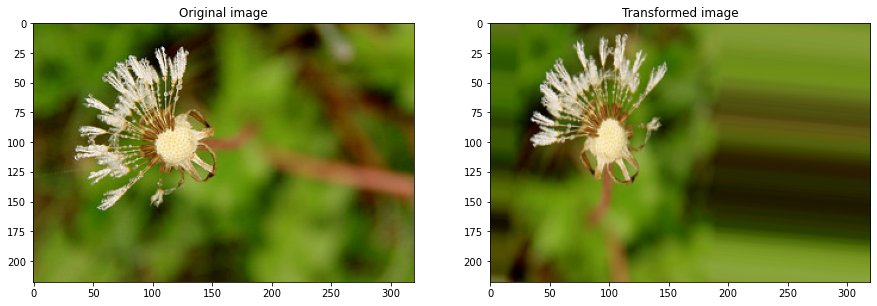

In [129]:
transform_fn = tf.keras.preprocessing.image.ImageDataGenerator(horizontal_flip=True,
                                                               width_shift_range=0.3,
                                                               height_shift_range=0.5,
                                                               rotation_range=90,
                                                               shear_range=0.2,
                                                               zoom_range=0.7)
transformed_array = transform_fn.random_transform(flower_array)
transformed_image = tf.keras.preprocessing.image.array_to_img(transformed_array)

plot_images(flower_image, transformed_image)

## Model Performance after Image Augmentation

In [130]:
# train and test data

train_df=pd.read_csv('data/flower_photos/train.csv')
test_df=pd.read_csv('data/flower_photos/test.csv')

In [132]:
# class names
class_names=train_df['class'].unique().tolist()
print('Flower classes: ',class_names)

Flower classes:  ['tulips', 'daisy', 'sunflowers', 'dandelion', 'roses']


In [133]:
# define parameters
img_size=60
img_depth=3

## Build batch generator 

In [134]:
def batch_generator(df, batchsize=32, train_mode=True):   
    
    img_generator= tf.keras.preprocessing.image.ImageDataGenerator(rotation_range=20,
                                                                   width_shift_range=0.2,
                                                                   height_shift_range=0.2,
                                                                   horizontal_flip=True)
    
    while True:       
        
        
        #Generate random numbers to pick images from dataset
        batch_nums = np.random.randint(0,df.shape[0],batchsize)
        
        #Initialize batch images array
        batch_images = np.zeros((batchsize,img_size, img_size,img_depth))
        
        #Initiate batch label array
        batch_labels = np.zeros((batchsize, len(class_names)))
        
        for i in range(batchsize):
            
            #Load image
            flower_image =  tf.keras.preprocessing.image.load_img('data/' + 
                                                                  df.loc[batch_nums[i]]['image_file'],
                                                                  target_size=(img_size, img_size))
            #Convert to array
            flower_image = tf.keras.preprocessing.image.img_to_array(flower_image)
            
            if(train_mode):
                #Apply transform
                flower_image =  img_generator.random_transform(flower_image)
            
            
            #Get the class
            img_class = df.loc[batch_nums[i]]['class']
            #Conver class to number
            img_class = class_names.index(img_class)
            #Convert class to one hot encoding
            img_class = tf.keras.utils.to_categorical(img_class, num_classes=len(class_names))
            
            #Update batch images and class arrays
            batch_images[i] = flower_image
            batch_labels[i] = img_class        
        
        yield batch_images, batch_labels          

## Build CNN Model


In [135]:
model = tf.keras.models.Sequential()
model.add(tf.keras.layers.BatchNormalization(input_shape=(img_size,img_size,3,)))
model.add(tf.keras.layers.Conv2D(32, kernel_size=(3,3), activation='relu'))
model.add(tf.keras.layers.Conv2D(64, kernel_size=(3,3), activation='relu'))
model.add(tf.keras.layers.MaxPool2D(pool_size=(2,2)))
model.add(tf.keras.layers.Flatten())
model.add(tf.keras.layers.Dense(128, activation='relu'))
model.add(tf.keras.layers.Dropout(0.25))

#Output layer
model.add(tf.keras.layers.Dense(len(class_names), activation='softmax'))

In [136]:
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

## Train the Model 

In [137]:
#Create train and test generator
batchsize = 64
train_generator = batch_generator(train_df, batchsize=batchsize) 
test_generator = batch_generator(test_df, batchsize=batchsize, train_mode=False)

In [138]:
model.fit_generator(train_generator, 
                          epochs=50,
                          steps_per_epoch= train_df.shape[0]//batchsize,
                          validation_data=test_generator,
                          validation_steps = test_df.shape[0]//batchsize)

<ipython-input-138-667db93080e2>:1: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  model.fit_generator(train_generator,


Epoch 1/50
45/45 [==============================] - 25s 552ms/step - loss: 2.1509 - accuracy: 0.2431 - val_loss: 1.4841 - val_accuracy: 0.2528
Epoch 2/50
45/45 [==============================] - 25s 561ms/step - loss: 1.3642 - accuracy: 0.3934 - val_loss: 1.2355 - val_accuracy: 0.4134
Epoch 3/50
45/45 [==============================] - 32s 717ms/step - loss: 1.2941 - accuracy: 0.4389 - val_loss: 1.1324 - val_accuracy: 0.5156
Epoch 4/50
45/45 [==============================] - 30s 677ms/step - loss: 1.1744 - accuracy: 0.5028 - val_loss: 1.0674 - val_accuracy: 0.5284
Epoch 5/50
45/45 [==============================] - 29s 646ms/step - loss: 1.1257 - accuracy: 0.5326 - val_loss: 1.1186 - val_accuracy: 0.5312
Epoch 6/50
45/45 [==============================] - 26s 584ms/step - loss: 1.0956 - accuracy: 0.5521 - val_loss: 1.0196 - val_accuracy: 0.5753
Epoch 7/50
45/45 [==============================] - 27s 599ms/step - loss: 1.0204 - accuracy: 0.5944 - val_loss: 0.9302 - val_accuracy: 0.6151

In [167]:
## The accuracy has significantly increased to 75.71% without any overfitting. This can be improved.

## Transfer Learning 

In [152]:
#Read train and test data
train_df=pd.read_csv('data/flower_photos/train.csv')
test_df=pd.read_csv('data/flower_photos/test.csv')

In [153]:
#Get class names
class_names=train_df['class'].unique().tolist()
print('Flower classes: ',class_names)

Flower classes:  ['tulips', 'daisy', 'sunflowers', 'dandelion', 'roses']


In [154]:
#Define some parameters
img_size = 224
img_depth = 3  

### Build Batch Generator 

In [155]:
def batch_generator(df, batchsize=32, train_mode=True):   
    
    img_generator= tf.keras.preprocessing.image.ImageDataGenerator(rotation_range=20,
                                                                   width_shift_range=0.2,
                                                                   height_shift_range=0.2,
                                                                   horizontal_flip=True)
    
    while True:       
        
        
        #Generate random numbers to pick images from dataset
        batch_nums = np.random.randint(0,df.shape[0],batchsize)
        
        #Initialize batch images array
        batch_images = np.zeros((batchsize,img_size, img_size,img_depth))
        
        #Initiate batch label array
        batch_labels = np.zeros((batchsize, len(class_names)))
        
        for i in range(batchsize):
            
            #Load image
            flower_image =  tf.keras.preprocessing.image.load_img('data/' + 
                                                                  df.loc[batch_nums[i]]['image_file'],
                                                                  target_size=(img_size, img_size))
            #Convert to array
            flower_image = tf.keras.preprocessing.image.img_to_array(flower_image)
            
            if(train_mode):
                #Apply transform
                flower_image =  img_generator.random_transform(flower_image)
            
            
            #Get the class
            img_class = df.loc[batch_nums[i]]['class']
            #Conver class to number
            img_class = class_names.index(img_class)
            #Convert class to one hot encoding
            img_class = tf.keras.utils.to_categorical(img_class, num_classes=len(class_names))
            
            #Update batch images and class arrays
            batch_images[i] = flower_image
            batch_labels[i] = img_class
        
        batch_images = tf.keras.applications.resnet50.preprocess_input(batch_images)
        
        yield batch_images, batch_labels          

### Load Pre-trained Model 

In [156]:
model = tf.keras.applications.resnet50.ResNet50(include_top=False, #Do not include FC layer at the end
                                          input_shape=(img_size,img_size, img_depth),
                                          weights='imagenet')

94781440/94765736 [==============================] - 42s 0us/step


In [157]:
model.summary()

Model: "resnet50"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 230, 230, 3)  0           ['input_1[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 112, 112, 64  9472        ['conv1_pad[0][0]']              
                                )                                                                 
                                                                                           

In [158]:
#Set pre-trained model layers to not trainable
for layer in model.layers:
    layer.trainable = False

In [159]:
print(len(model.layers))
for layer in model.layers[120:]:
    layer.trainable =  True    

175


In [160]:
model.output

<KerasTensor: shape=(None, 7, 7, 2048) dtype=float32 (created by layer 'conv5_block3_out')>

## Add FC Layer for new classes

In [161]:
#get Output layer of Pretrained model
x = model.output

#Flatten the output to feed to Dense layer
x = tf.keras.layers.Flatten()(x)

#Add one Dense layer
x = tf.keras.layers.Dense(200, activation='relu')(x)

#Add output layer
prediction = tf.keras.layers.Dense(len(class_names),activation='softmax')(x)

## Building Final Model for Classification

In [162]:
#Using Keras Model class
final_model = tf.keras.models.Model(inputs=model.input, #Pre-trained model input as input layer
                                    outputs=prediction) #Output layer added

In [163]:
final_model.compile(optimizer='adam',loss='categorical_crossentropy',metrics=['accuracy'])

In [164]:
final_model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 230, 230, 3)  0           ['input_1[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 112, 112, 64  9472        ['conv1_pad[0][0]']              
                                )                                                                 
                                                                                              

### Train the model 

In [165]:
#Create train and test generator
batchsize = 64
train_generator = batch_generator(train_df, batchsize=batchsize) #batchsize can be changed
test_generator = batch_generator(test_df, batchsize=batchsize, train_mode=False)

In [166]:
final_model.fit_generator(train_generator, 
                          epochs=10,
                          steps_per_epoch= train_df.shape[0]//batchsize,
                          validation_data=test_generator,
                          validation_steps = test_df.shape[0]//batchsize)

<ipython-input-166-025f07cb7c28>:1: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  final_model.fit_generator(train_generator,


Epoch 1/10
45/45 [==============================] - 464s 10s/step - loss: 6.9695 - accuracy: 0.6812 - val_loss: 26.0992 - val_accuracy: 0.3991
Epoch 2/10
45/45 [==============================] - 489s 11s/step - loss: 0.3759 - accuracy: 0.8913 - val_loss: 5.5320 - val_accuracy: 0.6974
Epoch 3/10
45/45 [==============================] - 501s 11s/step - loss: 0.2538 - accuracy: 0.9219 - val_loss: 0.7901 - val_accuracy: 0.8892
Epoch 4/10
45/45 [==============================] - 16384s 372s/step - loss: 0.1945 - accuracy: 0.9299 - val_loss: 1.7852 - val_accuracy: 0.8338
Epoch 5/10
45/45 [==============================] - 475s 11s/step - loss: 0.1453 - accuracy: 0.9507 - val_loss: 0.4427 - val_accuracy: 0.9176
Epoch 6/10
45/45 [==============================] - 491s 11s/step - loss: 0.1350 - accuracy: 0.9545 - val_loss: 0.5755 - val_accuracy: 0.8835
Epoch 7/10
45/45 [==============================] - 519s 12s/step - loss: 0.0966 - accuracy: 0.9698 - val_loss: 0.5453 - val_accuracy: 0.8793
Ep

In [168]:
# The accuracy comes out to be 91.90% which is a great improvement.
## Techniques: 1. Data Augmentation 
##             2. Tranfer Learning